# Batch Bayesian Optimization with Batch Expected Improvement, Local Penalization, Kriging Believer and GIBBON

Sometimes it is practically convenient to query several points at a time. This notebook demonstrates four ways to perfom batch Bayesian optimization with Trieste.

In [1]:
import numpy as np
import tensorflow as tf
from util.plotting import plot_acq_function_2d
import matplotlib.pyplot as plt
import trieste

np.random.seed(1234)
tf.random.set_seed(1234)

## Describe the problem

In this example, we consider the same problem presented in our `expected_improvement` notebook, i.e. seeking the minimizer of the two-dimensional Branin function.

We begin our optimization after collecting five function evaluations from random locations in the search space.

In [2]:
from trieste.objectives import scaled_branin, SCALED_BRANIN_MINIMUM
from trieste.objectives.utils import mk_observer
from trieste.space import Box

observer = mk_observer(scaled_branin)
search_space = Box([0, 0], [1, 1])

num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

## Surrogate model

Just like in purely sequential optimization, we fit a surrogate Gaussian process model to the initial data. The GPflow models cannot be used directly in our Bayesian optimization routines, so we build a GPflow's `GPR` model and pass it to the `GaussianProcessRegression` wrapper.

In [3]:
import gpflow
import tensorflow_probability as tfp
from trieste.models.gpflow.models import GaussianProcessRegression


def build_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=[0.2, 0.2])
    prior_scale = tf.cast(1.09, dtype=tf.float64)
    kernel.variance.prior = tfp.distributions.LogNormal(
        tf.cast(-2.0, dtype=tf.float64), prior_scale
    )
    kernel.lengthscales.prior = tfp.distributions.LogNormal(
        tf.math.log(kernel.lengthscales), prior_scale
    )
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)
    return GaussianProcessRegression(gpr)


model = build_model(initial_data)

## Batch acquisition functions.
To perform batch BO, we must define a batch acquisition function. Four batch acquisition functions supported in Trieste are `BatchMonteCarloExpectedImprovement`, `LocalPenalization` (see <cite data-cite="Gonzalez:2016"/>), `Fantasizer` (see <cite data-cite="ginsbourger2010kriging"/>) and `GIBBON` (see <cite data-cite="Moss:2021"/>).

Although all these acquisition functions recommend batches of diverse query points, the batches are chosen in very different ways. `BatchMonteCarloExpectedImprovement` jointly allocates the batch of points as those with the largest expected improvement over our current best solution. In contrast, the `LocalPenalization` greedily builds the batch, sequentially adding the maximizers of the standard (non-batch) `ExpectedImprovement` function penalized around the current pending batch points. `Fantasizer` works similarly, but instead of penalizing the acquisition model, it iteratively updates the predictive equations after "fantasizing" obervations at the previously chosen query points. `GIBBON` also builds batches in a greedy manner but seeks batches that provide a large reduction in our uncertainty around the maximum value of the objective function.

In practice, `BatchMonteCarloExpectedImprovement` can be expected to have superior performance for small batches and dimension (`batch_size`<4) but scales poorly for larger batches, especially in high dimension. `Fantasizer` complexity scales cubically with the batch size, which also limits its use to small batches. `LocalPenalization` is computationally cheapest and may be the best fit for large batches.

Note that all these acquisition functions have controllable parameters. In particular, `BatchMonteCarloExpectedImprovement` is computed using a Monte-Carlo method (so it requires a `sample_size`), but uses a reparametrisation trick to make it deterministic. The `LocalPenalization` has parameters controlling the degree of penalization that must be estimated from a random sample of `num_samples` model predictions (we recommend at least 1_000 for each search space dimension). Similarly, `GIBBON` requires a `grid_size` parameter that controls its approximation accuracy (which should also be larger than 1_000 for each search space dimension). `Fantasizer` requires a method for "fantasizing" the observations, which can be done by sampling from the GP posterior or by using the GP posterior mean (a.k.a "kriging believer" heuristic, our default setup).


First, we collect the batch of ten points recommended by `BatchMonteCarloExpectedImprovement` ...

In [4]:
from trieste.acquisition.function import BatchMonteCarloExpectedImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization

monte_carlo_sample_size = 1000
batch_ei_acq = BatchMonteCarloExpectedImprovement(
    sample_size=monte_carlo_sample_size, jitter=1e-5
)
batch_size = 10
batch_ei_acq_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=batch_size, builder=batch_ei_acq
)
points_chosen_by_batch_ei = batch_ei_acq_rule.acquire_single(
    search_space, model, dataset=initial_data
)

then we do the same with `LocalPenalization` ...

In [5]:
from trieste.acquisition import LocalPenalization

sample_size = 2000
local_penalization_acq = LocalPenalization(
    search_space, num_samples=sample_size
)
local_penalization_acq_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=batch_size, builder=local_penalization_acq
)
points_chosen_by_local_penalization = (
    local_penalization_acq_rule.acquire_single(
        search_space, model, dataset=initial_data
    )
)

then with `Fantasizer` ...

In [6]:
from trieste.acquisition import Fantasizer

kriging_believer_acq = Fantasizer()
kriging_believer_acq_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=batch_size, builder=kriging_believer_acq
)
points_chosen_by_kriging_believer = kriging_believer_acq_rule.acquire_single(
    search_space, model, dataset=initial_data
)

and finally we use `GIBBON`.

In [7]:
from trieste.acquisition.function import GIBBON

gibbon_acq = GIBBON(search_space, grid_size=sample_size)
gibbon_acq_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=batch_size, builder=gibbon_acq
)
points_chosen_by_gibbon = gibbon_acq_rule.acquire_single(
    search_space, model, dataset=initial_data
)

We can now visualize the batch of 10 points chosen by each of these methods overlayed on the standard `ExpectedImprovement` acquisition function. `BatchMonteCarloExpectedImprovement` and `Fantasizer` choose a more diverse set of points, whereas `LocalPenalization` and `GIBBON` focus evaluations in the most promising areas of the space.

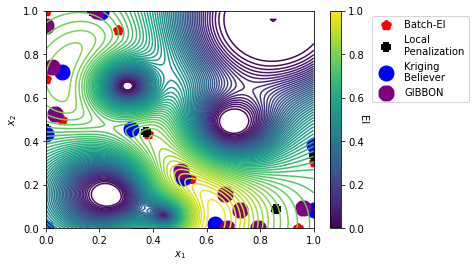

In [8]:
from trieste.acquisition.function import ExpectedImprovement

# plot standard EI acquisition function
ei = ExpectedImprovement()
ei_acq_function = ei.prepare_acquisition_function(model, dataset=initial_data)
plot_acq_function_2d(
    ei_acq_function, [0, 0], [1, 1], contour=True, grid_density=100
)

plt.scatter(
    points_chosen_by_batch_ei[:, 0],
    points_chosen_by_batch_ei[:, 1],
    color="red",
    lw=5,
    label="Batch-EI",
    marker="*",
    zorder=1,
)
plt.scatter(
    points_chosen_by_local_penalization[:, 0],
    points_chosen_by_local_penalization[:, 1],
    color="black",
    lw=10,
    label="Local \nPenalization",
    marker="+",
)
plt.scatter(
    points_chosen_by_kriging_believer[:, 0],
    points_chosen_by_kriging_believer[:, 1],
    color="blue",
    lw=10,
    label="Kriging \nBeliever",
    marker="o",
)
plt.scatter(
    points_chosen_by_gibbon[:, 0],
    points_chosen_by_gibbon[:, 1],
    color="purple",
    lw=10,
    label="GIBBON",
    marker="X",
)


plt.legend(bbox_to_anchor=(1.2, 1), loc="upper left")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
cbar = plt.colorbar()
cbar.set_label("EI", rotation=270)

## Run the batch optimization loop
We can now run a batch Bayesian optimization loop by defining a `BayesianOptimizer` with one of our batch acquisition functions.

We reuse the same ` EfficientGlobalOptimization` rule as in the purely sequential case, however we pass in one of batch acquisition functions and set `num_query_points`>1.

We'll run each method for ten steps for batches of three points.

First we run ten steps of `BatchMonteCarloExpectedImprovement` ...

In [9]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

batch_ei_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=3, builder=batch_ei_acq
)
num_steps = 10
qei_result = bo.optimize(
    num_steps, initial_data, model, acquisition_rule=batch_ei_rule
)

Optimization completed without errors


then we repeat the same optimization with `LocalPenalization`...

In [10]:
local_penalization_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=3, builder=local_penalization_acq
)
local_penalization_result = bo.optimize(
    num_steps, initial_data, model, acquisition_rule=local_penalization_rule
)

Optimization completed without errors


then with `Fantasizer`...

In [11]:
kriging_believer_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=3, builder=kriging_believer_acq
)
kriging_believer_result = bo.optimize(
    num_steps, initial_data, model, acquisition_rule=kriging_believer_rule
)

Optimization completed without errors


and finally with the `GIBBON` acquisition function.

In [12]:
gibbon_rule = EfficientGlobalOptimization(  # type: ignore
    num_query_points=3, builder=gibbon_acq
)
gibbon_result = bo.optimize(
    num_steps, initial_data, model, acquisition_rule=gibbon_rule
)

Optimization completed without errors


We can visualize the performance of each of these methods by plotting the trajectory of the regret (suboptimality) of the best observed solution as the optimization progresses. We denote this trajectory with the orange line, the start of the optimization loop with the blue line and the best overall point as a purple dot.

For this particular problem (and random seed), we see that `GIBBON` provides the fastest initial optimization but all methods have overall a roughly similar performance.

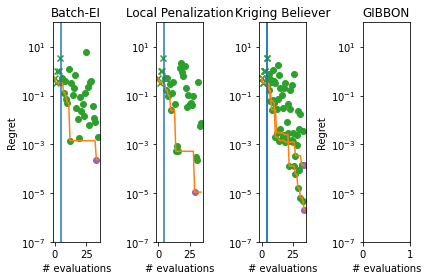

In [13]:
from util.plotting import plot_regret

qei_observations = (
    qei_result.try_get_final_dataset().observations - SCALED_BRANIN_MINIMUM
)
qei_min_idx = tf.squeeze(tf.argmin(qei_observations, axis=0))
local_penalization_observations = (
    local_penalization_result.try_get_final_dataset().observations
    - SCALED_BRANIN_MINIMUM
)
local_penalization_min_idx = tf.squeeze(
    tf.argmin(local_penalization_observations, axis=0)
)
kriging_believer_observations = (
    kriging_believer_result.try_get_final_dataset().observations
    - SCALED_BRANIN_MINIMUM
)
kriging_believer_min_idx = tf.squeeze(
    tf.argmin(kriging_believer_observations, axis=0)
)
gibbon_observations = (
    gibbon_result.try_get_final_dataset().observations - SCALED_BRANIN_MINIMUM
)
gibbon_min_idx = tf.squeeze(tf.argmin(gibbon_observations, axis=0))


fig, ax = plt.subplots(1, 4)
plot_regret(qei_observations.numpy(), ax[0], num_init=5, idx_best=qei_min_idx)
ax[0].set_yscale("log")
ax[0].set_ylabel("Regret")
ax[0].set_ylim(0.0000001, 100)
ax[0].set_xlabel("# evaluations")
ax[0].set_title("Batch-EI")

plot_regret(
    local_penalization_observations.numpy(),
    ax[1],
    num_init=5,
    idx_best=local_penalization_min_idx,
)
ax[1].set_yscale("log")
ax[1].set_xlabel("# evaluations")
ax[1].set_ylim(0.0000001, 100)
ax[1].set_title("Local Penalization")

plot_regret(
    kriging_believer_observations.numpy(),
    ax[2],
    num_init=5,
    idx_best=kriging_believer_min_idx,
)
ax[2].set_yscale("log")
ax[2].set_xlabel("# evaluations")
ax[2].set_ylim(0.0000001, 100)
ax[2].set_title("Kriging Believer")

plot_regret(
    gibbon_observations.numpy(), ax[2], num_init=5, idx_best=gibbon_min_idx
)
ax[3].set_yscale("log")
ax[3].set_ylabel("Regret")
ax[3].set_ylim(0.0000001, 100)
ax[3].set_xlabel("# evaluations")
ax[3].set_title("GIBBON")

fig.tight_layout()

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)